## 데이터셋 임포트하기

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os

pd.set_option('display.max_columns', 400)

# for local execution
current_dir = os.path.abspath('.')
dataset_dir = os.path.join(os.path.abspath(current_dir + "/../"), 'dataset_kaggle_IEEE_CIS_Fraud_Detection')
print(os.listdir(dataset_dir))

['sample_submission.csv', 'test_identity.csv', 'test_transaction.csv', 'train_identity.csv', 'train_transaction.csv']


In [6]:
# 데이터 로딩(for Kaggle Kernel)
# train_tran = pd.read_csv('../input/train_transaction.csv', index_col='TransactionID')
# train_iden = pd.read_csv('../input/train_identity.csv', index_col='TransactionID')
# test_tran = pd.read_csv('../input/test_transaction.csv', index_col='TransactionID')
# test_iden = pd.read_csv('../input/test_identity.csv', index_col='TransactionID')
# sample_sub = pd.read_csv('../input/sample_submission.csv', index_col='TransactionID')

# 데이터 로딩 (for local execution)
train_tran = pd.read_csv(os.path.join(dataset_dir, 'train_transaction.csv'))
train_iden = pd.read_csv(os.path.join(dataset_dir, 'train_identity.csv'))
test_tran = pd.read_csv(os.path.join(dataset_dir, 'test_transaction.csv'))
test_iden = pd.read_csv(os.path.join(dataset_dir, 'test_identity.csv'))
sample_sub = pd.read_csv(os.path.join(dataset_dir, 'sample_submission.csv'))

Train과 Test 데이터는 모두 각각 Identity와 Transaction 두 개의 .csv파일로 나뉘어 있습니다. 이는 'TransactionID'라는 column으로 join되어 있습니다. 단, `train_identity.csv`와 `train_transaction.csv`의 모든 거래 내역(transactions)들이 서로 완벽히 일치하지는 않습니다. 

* <b>`train_transaction.csv`의 범주형 번수</b>
    * TransactionID : reference datetime(실제 timestamp와 다름)으로부터의 timedelta(시간변화량)을 의미
    * TransactionAmt : USD를 이용해 지불된 거래 금액
    * ProductCD : 제품 code(각 거래마다의 제품 코드)
    * card1 ~ card6 : 거래에 사용한 카드 정보(카드 타입, 카드 카테고리, 카드 발행은행, 국가 등)
    * addr1 ~ addr2 : 주소
    * dist : 거리(distance)
    * P_emaildomain, R_emaildomain : 구매자 및 수신자 이메일 도메인 주소
    * C1 ~ C14 : 얼마나 많은 주소가 지불 카드와 관련있는지에 대한 횟수(counting)로, 실제 의미는 비식별 처리되어(masked)있음.
    * D1 ~ D15 : 이전 거래일과의 시간변화량(timedelta)
    * M1 ~ M9 : 카드에 적힌 이름이나 주소 등등이 일치하는지 여부


* <b>`train_identity.csv`의 범주형 변수</b>
    * DeviceType
    * DeviceInfo
    * id_12 ~ id_38 : 트랜잭션과 관련된 식별 정보 (네트워크 연결 정보 - IP, ISP, Proxy 등) 및 디지털 서명(UA/browser/OS/version 등)을 의미하며, Vesta의 사기 방지 시스템 및 디지털 보안 파트너사가 함께 수집했습니다. 필드의 이름들은 개인정보 보호를 위해 비식별 처리되어 있습니다. 
   
이번 대회의 데이터는 메모리 문제를 유발할 수 있기 때문에, Memory reduce를 진행하여야 합니다. 불러오는 것은 물론 처리에도 시간이 많이 소비되므로, 메모리 사용량을 줄여 보겠습니다. 이번 대회의 데이터 타입들은 대부분 int64, float64로 이루어져 있으며, 실제 데이터는 int64 타입이지만 실질적인 데이터 범위가 int16에만 속한다면 메모리를 줄이는 것이 효율적일 것입니다. (https://hwiyong.tistory.com/238 참고)


#### 데이터셋의 메모리 줄이기 

In [7]:
## Dataframe의 메모리 사이즈를 줄이기 위한 함수
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## REducing memory
train_tran = reduce_mem_usage(train_tran)
train_iden = reduce_mem_usage(train_iden)
test_tran = reduce_mem_usage(test_tran)
test_iden = reduce_mem_usage(test_iden)

Mem. usage decreased to 542.35 Mb (69.4% reduction)
Mem. usage decreased to 25.86 Mb (42.7% reduction)
Mem. usage decreased to 472.59 Mb (68.9% reduction)
Mem. usage decreased to 25.44 Mb (42.7% reduction)


In [8]:
train_tran.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [10]:
test_tran.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3663549,18403224,31.953125,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,203.0,NaN,NaN,NaN,409.0,T,T,F,NaN,NaN,F,T,T,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,47.950001,0.000000,0.0000,47.950001,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.0000,47.950001,0.0000,0.000000,0.0000,0.000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.000000,W,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,4.0,NaN,aol.com,NaN,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,NaN,231.0,634.0,NaN,NaN,NaN,634.0,T,F,F,M0,NaN,F,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

## Explore Data 
첫번째로 Train과 Test 데이터에 대한 time series 분할을 해볼 것입니다. `TransactionDT` feature는 주어진 참조 시간(reference datetime, 현실의 시간과 다름)에 대한 시간 변화량(timedelta)입니다. train과 test 데이터가 시간에 따라 분리되어 있으며, 두 데이터셋 사이에 약간 간격이 존재하는 것을 확인할 수 있습니다. 이는 추후 CV(Cross validation)기법을 사용해야 하는지에 대한 여부 결정에 영향을 미칩니다. 이제 다른 train, test의 feature들에 대해서도 분석해 보겠습니다.

### train_transaction.csv의 정수형 데이터 피쳐들 살펴보기
#### Training set에 들어 있는 Target의 분포 살펴보기

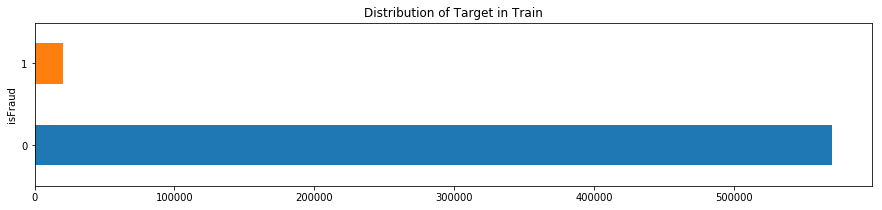

train.df안에 존재하는 사기 거래의 비율 :  3.4990009144173126


In [12]:
train_tran.groupby('isFraud') \
    .count()['TransactionID'] \
    .plot(kind='barh',
          title='Distribution of Target in Train',
          figsize=(15, 3))
plt.show()

print('train.df안에 존재하는 사기 거래의 비율 : ', train_tran['isFraud'].mean() * 100)

#### 거래금액(`TransactionAmt`)의 분산 확인해보기
매우 큰 트랜잭션이 전체를 흔드는 것을 방지하기 위해 log 정규화를 수행한 후 plot을 그려 봅니다. 로그로 변환하는 과정 때문에 0~1 사이의 모든 값은 음수로 표시됩니다.
이제 정상 거래와 사기 거래에 대해서도 plot을 그려 보겠습니다. 

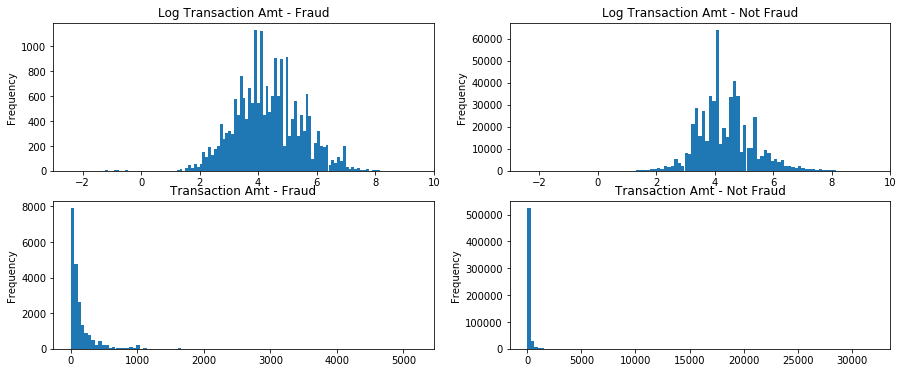

In [16]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 6))
train_tran.loc[train_tran['isFraud'] == 1] \
    ['TransactionAmt'].apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='Log Transaction Amt - Fraud',
          xlim=(-3, 10),
         ax= ax1)
train_tran.loc[train_tran['isFraud'] == 0] \
    ['TransactionAmt'].apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='Log Transaction Amt - Not Fraud',
          xlim=(-3, 10),
         ax=ax2)
train_tran.loc[train_tran['isFraud'] == 1] \
    ['TransactionAmt'] \
    .plot(kind='hist',
          bins=100,
          title='Transaction Amt - Fraud',
         ax= ax3)
train_tran.loc[train_tran['isFraud'] == 0] \
    ['TransactionAmt'] \
    .plot(kind='hist',
          bins=100,
          title='Transaction Amt - Not Fraud',
         ax=ax4)
plt.show()

사기 거래는 평균 거래 금액이 더 높아 보입니다.

#### `TransactionDT` feature로 시간변화에 따른 분포 확인해보기

아래에서 볼 수 있듯 trian_tran과 test_tran간에는 약간의 시간 간격이 벌어져 있습니다. 이는 추후 cross validation을 해야 할지 말지에 영향을 미칩니다. 

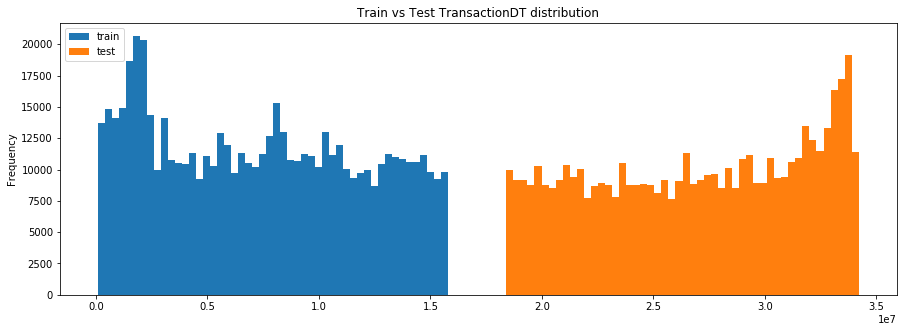

In [23]:
train_tran['TransactionDT'].plot(kind='hist',
                                        figsize=(15, 5),
                                        label='train',
                                        bins=50,
                                        title='Train vs Test TransactionDT distribution')
test_tran['TransactionDT'].plot(kind='hist',
                                       label='test',
                                       bins=50)
plt.legend()
plt.show()

#### train_transaction.csv의 `ProductCD` 찍어보기

In [37]:
train_tran.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

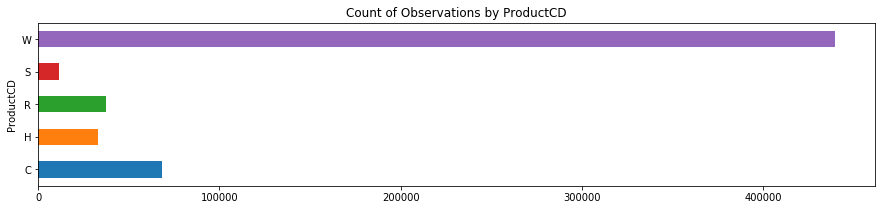

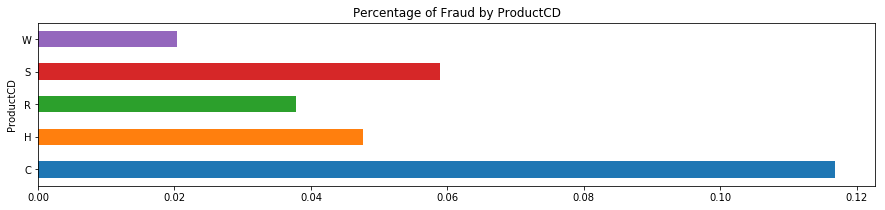

In [45]:
# ProductCD의 관측 횟수
train_tran.groupby('ProductCD') \
    ['TransactionID'].count() \
    .sort_index() \
    .plot(kind='barh',
          figsize=(15, 3),
         title='Count of Observations by ProductCD')
plt.show()

# ProductCD별 사기의 비율
train_tran.groupby('ProductCD')['isFraud'] \
    .mean() \
    .sort_index() \
    .plot(kind='barh',
          figsize=(15, 3),
         title='Percentage of Fraud by ProductCD')
plt.show()

### train_transaction.csv의 카테고리형 피쳐들 살펴보기
#### `card1`~`card6` 살펴보기

In [65]:
card_cols = [c for c in train_tran.columns if 'card' in c]
train_tran[card_cols].head()

,card1,card2,card3,card4,card5,card6
0,13926,NaN,150.0,discover,142.0,credit
1,2755,404.0,150.0,mastercard,102.0,credit
2,4663,490.0,150.0,visa,166.0,debit
3,18132,567.0,150.0,mastercard,117.0,debit
4,4497,514.0,150.0,mastercard,102.0,credit


In [66]:
color_idx = 0
for c in card_cols:
    if train_tran[c].dtype in ['float64','int64']:
        train_tran[c].plot(kind='hist',
                                      title=c,
                                      bins=50,
                                      figsize=(15, 2),
                                      color=color_pal[color_idx])
    color_idx += 1
    plt.show()

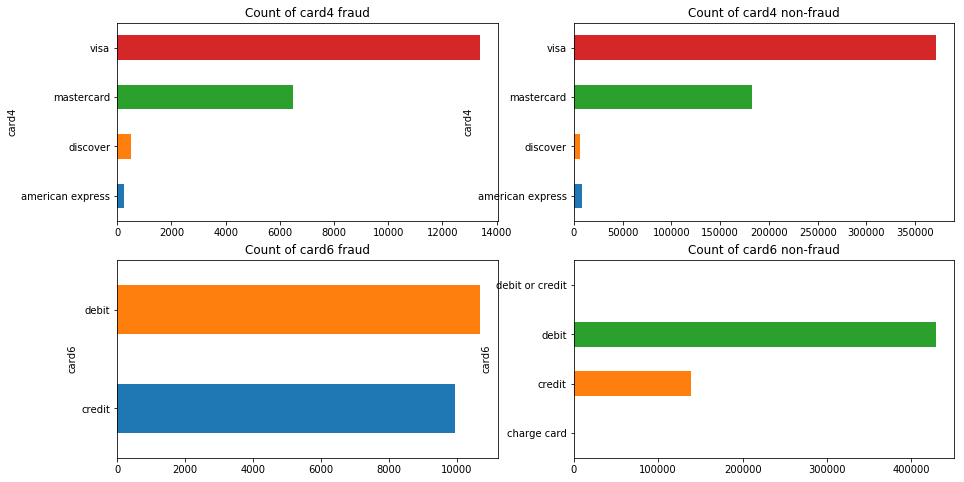

In [67]:
train_transaction_fr = train_tran.loc[train_tran['isFraud'] == 1]
train_transaction_nofr = train_tran.loc[train_tran['isFraud'] == 0]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 8))

train_transaction_fr.groupby('card4')['card4'].count().plot(kind='barh', ax=ax1, title='Count of card4 fraud')
train_transaction_nofr.groupby('card4')['card4'].count().plot(kind='barh', ax=ax2, title='Count of card4 non-fraud')
train_transaction_fr.groupby('card6')['card6'].count().plot(kind='barh', ax=ax3, title='Count of card6 fraud')
train_transaction_nofr.groupby('card6')['card6'].count().plot(kind='barh', ax=ax4, title='Count of card6 non-fraud')
plt.show()

#### `add1`~`addr2` 살펴보기
`dist` feature는 단순 거리이므로 따로 분석하지 않았습니다. 

In [69]:
# NA값 체크하기
print(' addr1 - has {} NA values'.format(train_tran['addr1'].isna().sum()))
print(' addr2 - has {} NA values'.format(train_tran['addr2'].isna().sum()))

 addr1 - has 65706 NA values
 addr2 - has 65706 NA values


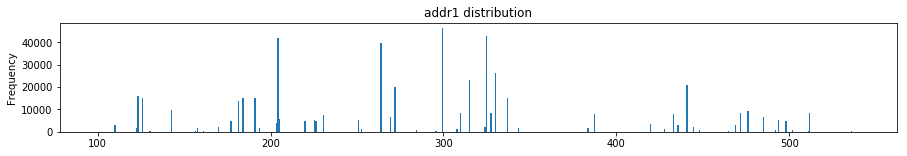

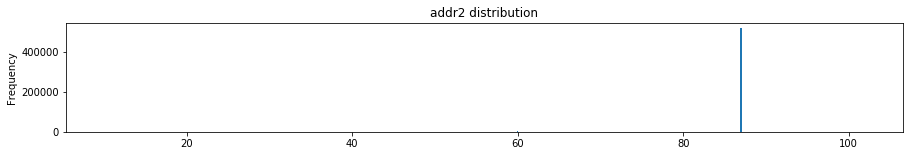

In [70]:
train_tran['addr1'].plot(kind='hist', bins=500, figsize=(15, 2), title='addr1 distribution')
plt.show()
train_tran['addr2'].plot(kind='hist', bins=500, figsize=(15, 2), title='addr2 distribution')
plt.show()

#### `c1`~`c14` 살펴보기
c1~c14는 숫자로 된 열들이므로 pairplot을 그려 보도록 합니다. pairplot을 그려 보는 것은 특정 feature가 다른 feature과 차이가 있을 경우 유용한 방법입니다. 

    C1   C2   C3   C4   C5   C6   C7   C8   C9  C10  C11  C12   C13  C14
0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  2.0  0.0   1.0  1.0
1  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   1.0  1.0
2  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   1.0  1.0
3  2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0  0.0  1.0  0.0  25.0  1.0
4  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0   1.0  1.0


C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


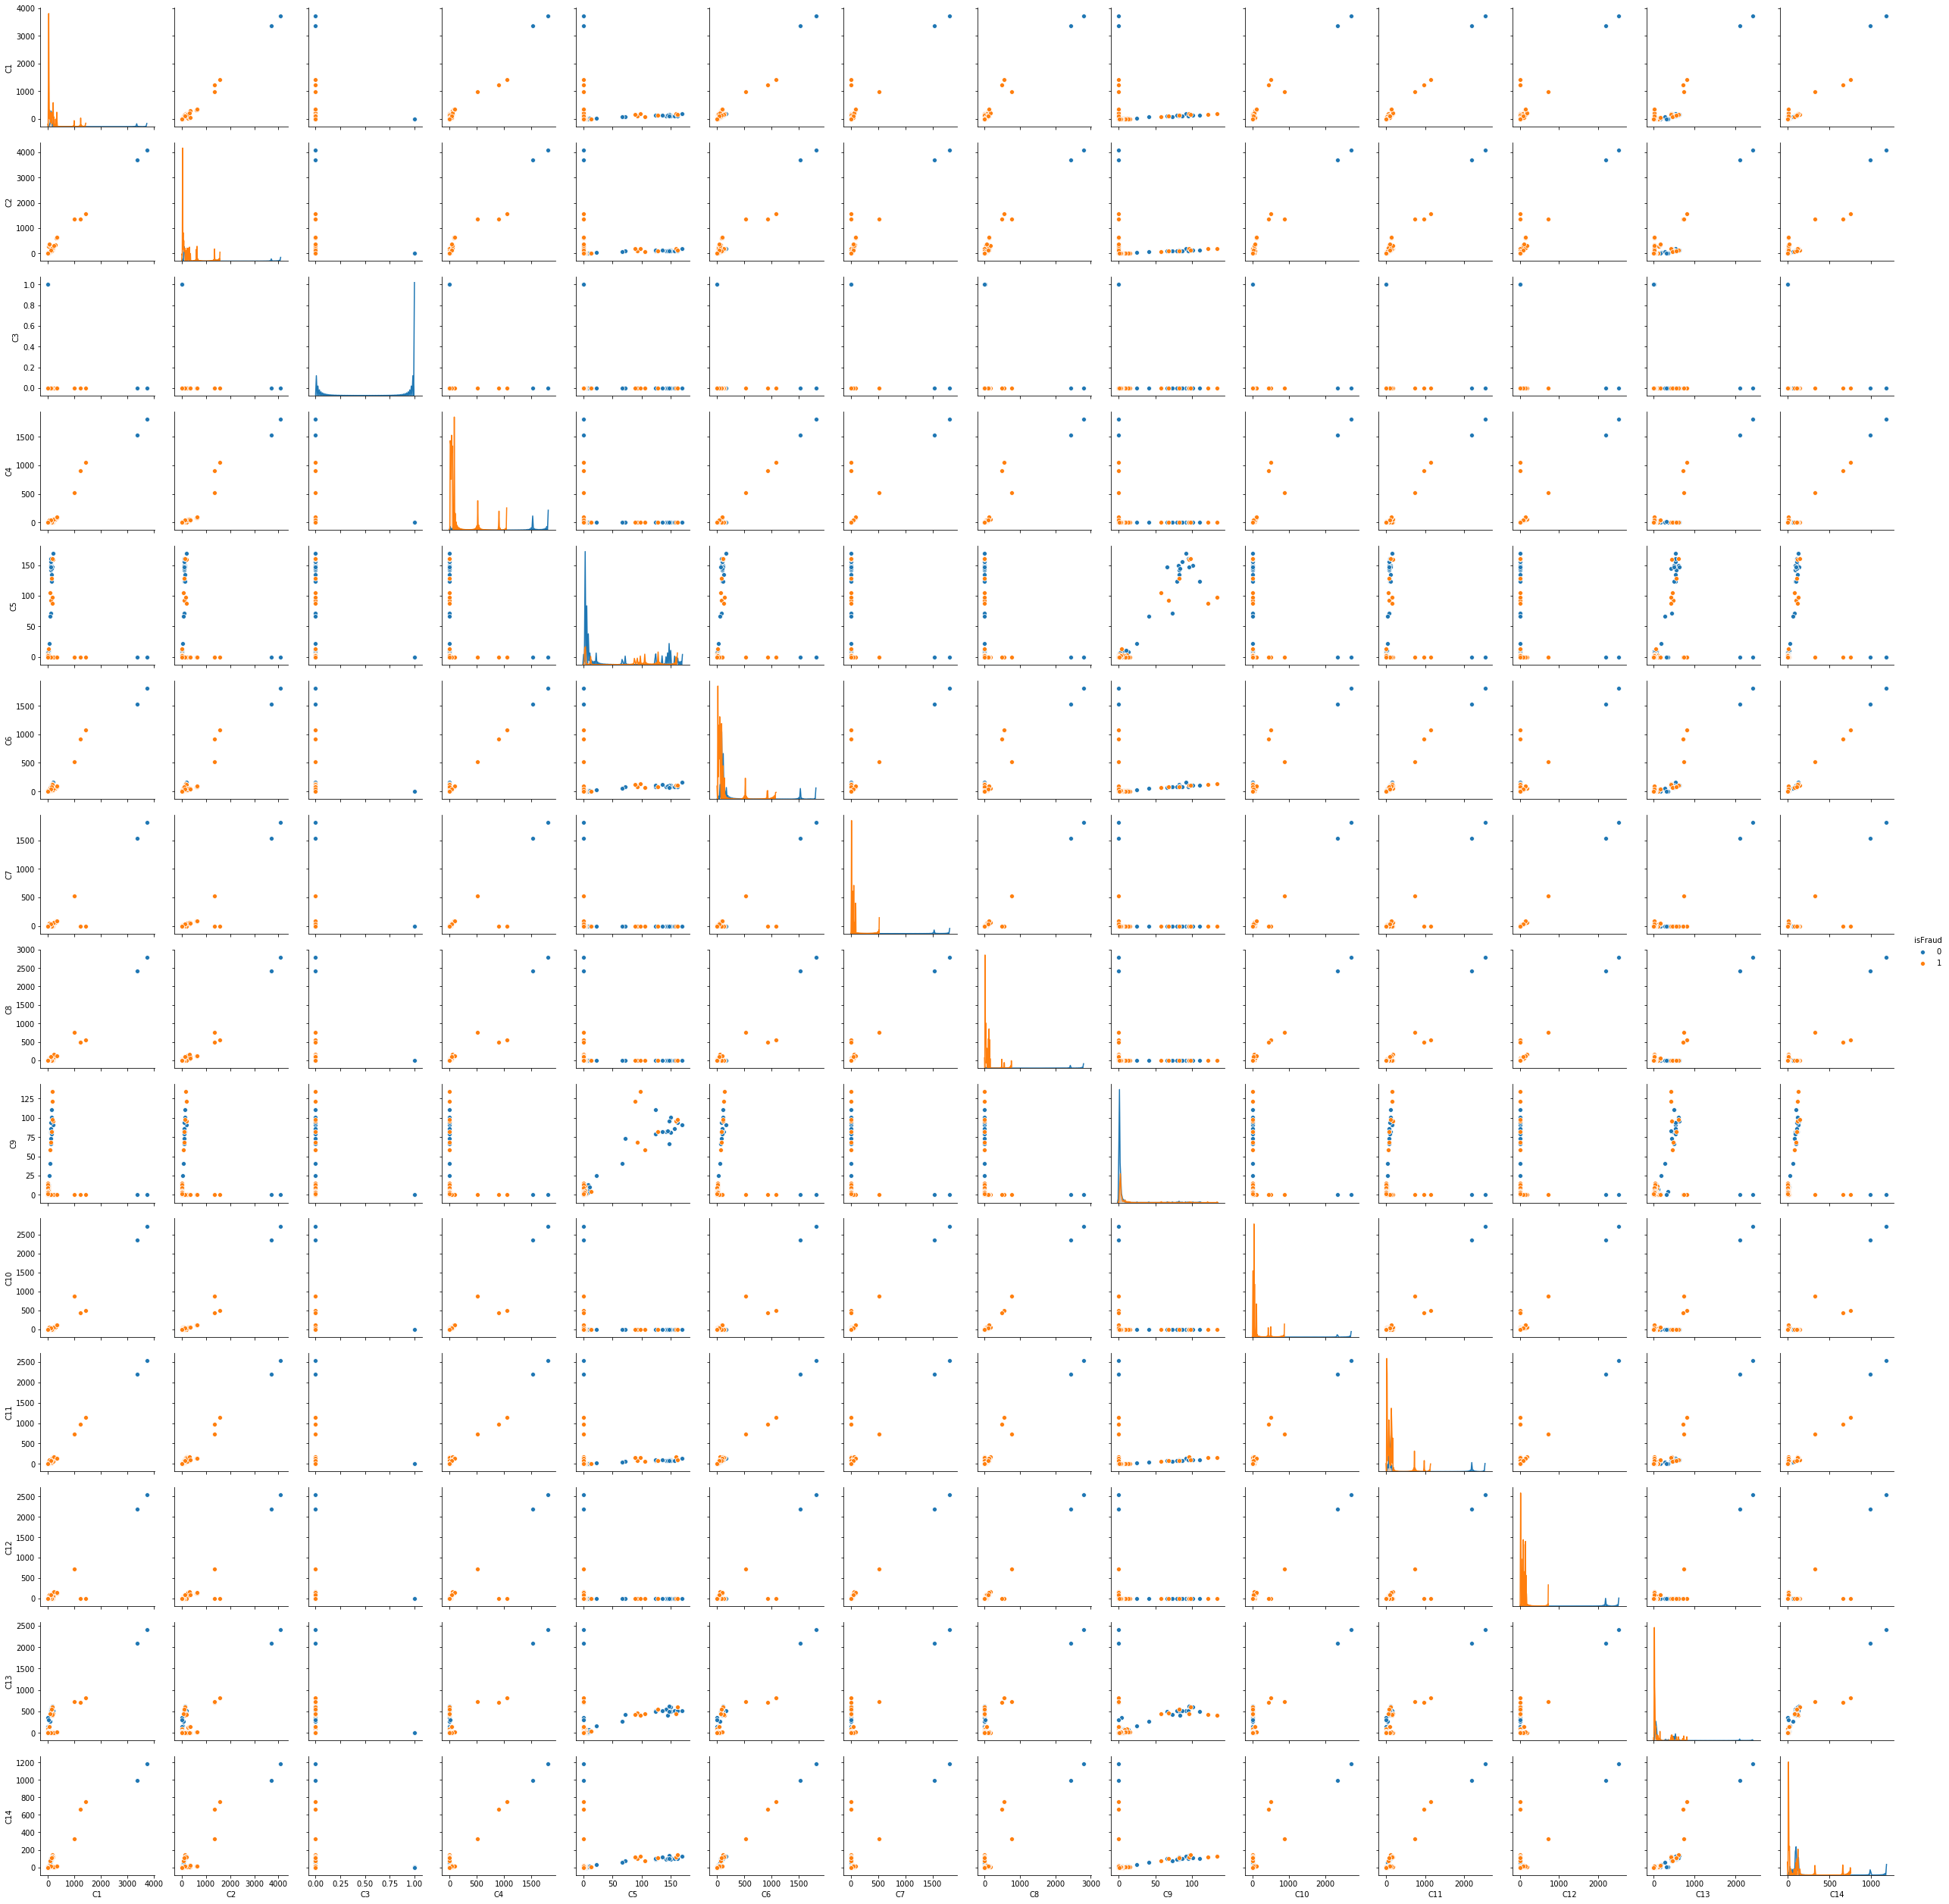

In [75]:
c_cols = [c for c in train_tran if c[0] == 'C']
print(train_tran[c_cols].head())

# 500개의 사기 및 정상 거래를 샘플링해 그래프를 그립니다.
sampled_train = pd.concat([train_tran.loc[train_tran['isFraud'] == 0].sample(500),
          train_tran.loc[train_tran['isFraud'] == 1].sample(500)])

sns.pairplot(sampled_train, 
             hue='isFraud',
            vars=c_cols)
plt.show()

#### `D1`~`D9` features에 대해서도 그래프 그려보기

      D1     D2    D3    D4   D5  D6  D7  D8  D9   D10    D11  D12  D13  D14  \
0   14.0    NaN  13.0   NaN  NaN NaN NaN NaN NaN  13.0   13.0  NaN  NaN  NaN   
1    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   0.0    NaN  NaN  NaN  NaN   
2    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   0.0  315.0  NaN  NaN  NaN   
3  112.0  112.0   0.0  94.0  0.0 NaN NaN NaN NaN  84.0    NaN  NaN  NaN  NaN   
4    0.0    NaN   NaN   NaN  NaN NaN NaN NaN NaN   NaN    NaN  NaN  NaN  NaN   

     D15  
0    0.0  
1    0.0  
2  315.0  
3  111.0  
4    NaN  


C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


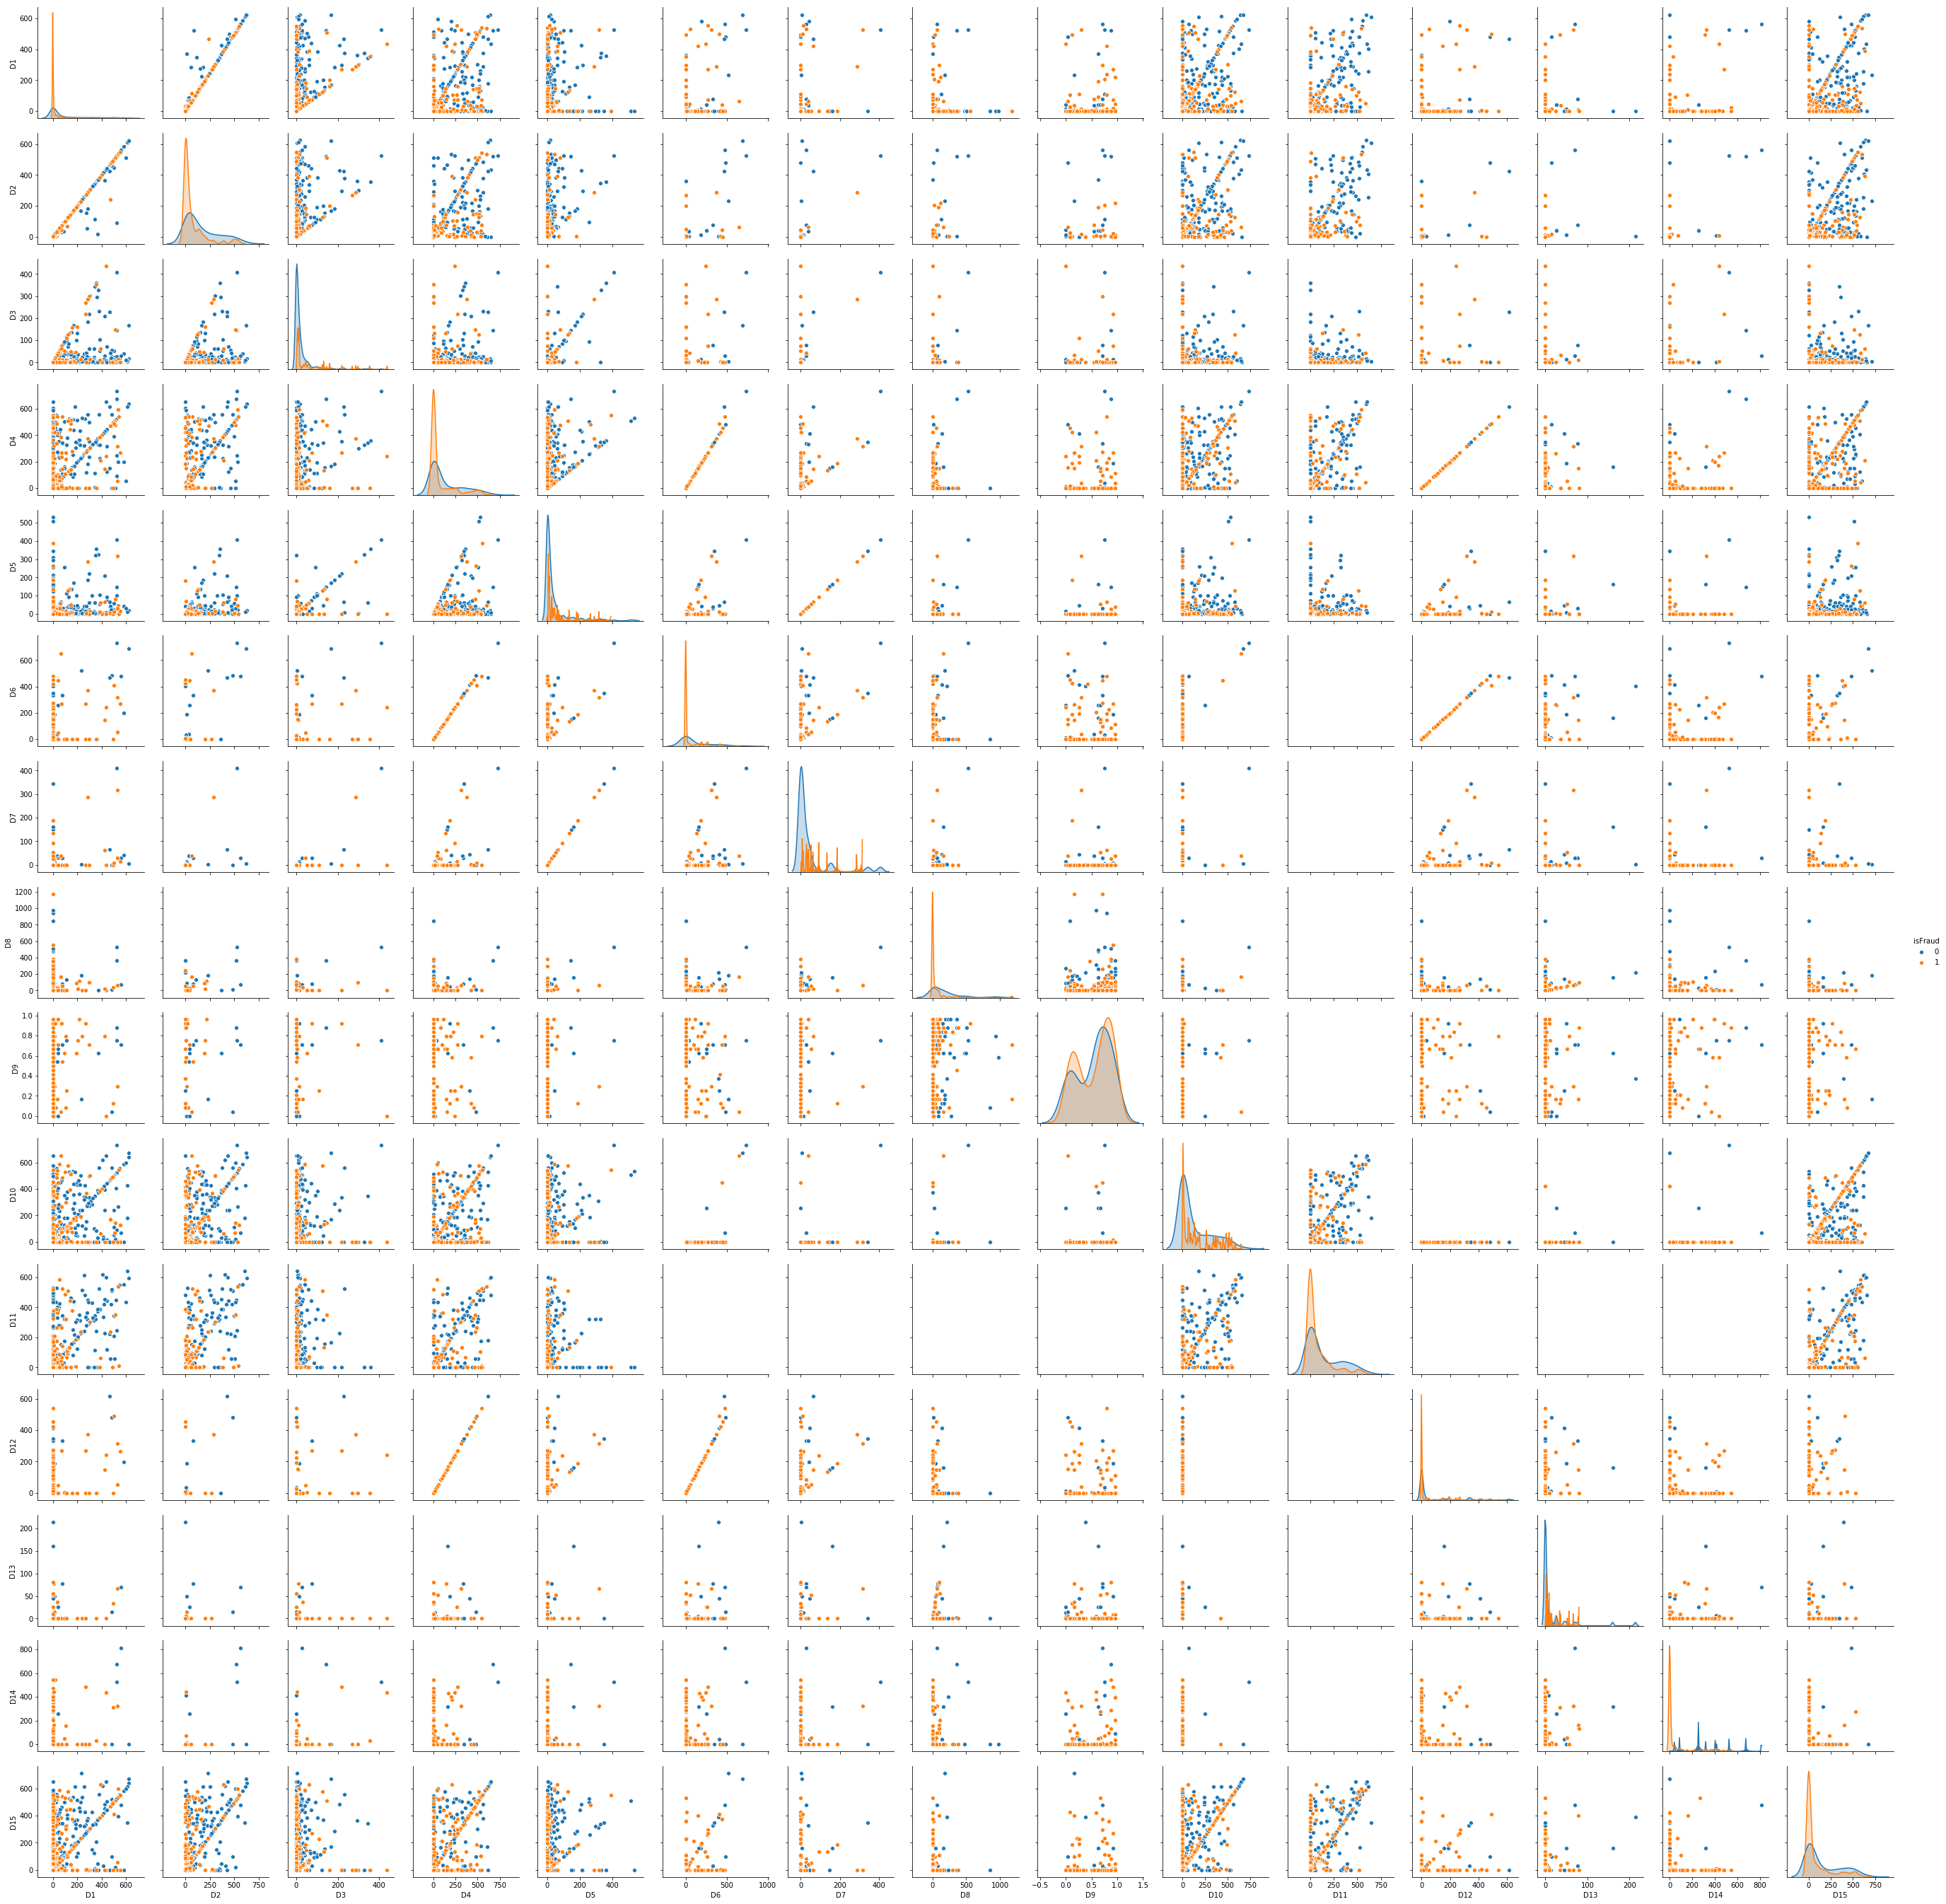

In [76]:
d_cols = [c for c in train_tran if c[0] == 'D']
print(train_tran[d_cols].head())

sns.pairplot(sampled_train, 
             hue='isFraud',
            vars=d_cols)
plt.show()

#### `M1`~`M9` feature 살펴보기
`M1`~`M9`는 T, F, NaN값을 갖고 있습니다. 

    M1   M2   M3   M4   M5   M6   M7   M8   M9
0    T    T    T   M2    F    T  NaN  NaN  NaN
1  NaN  NaN  NaN   M0    T    T  NaN  NaN  NaN
2    T    T    T   M0    F    F    F    F    F
3  NaN  NaN  NaN   M0    T    F  NaN  NaN  NaN
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN


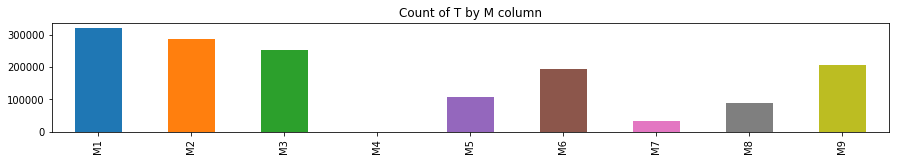

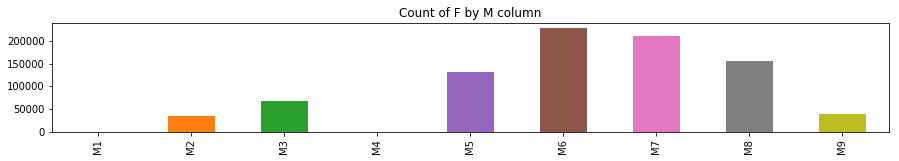

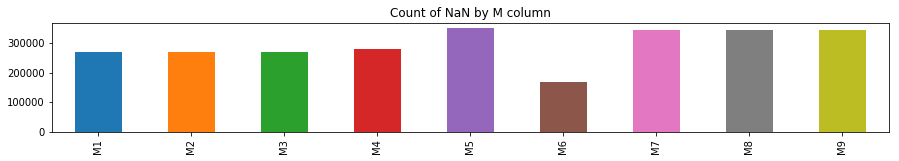

In [79]:
m_cols = [c for c in train_tran if c[0] == 'M']
print(train_tran[m_cols].head())

(train_tran[m_cols] == 'T').sum().plot(kind='bar',
                                              title='Count of T by M column',
                                              figsize=(15, 2))
plt.show()
(train_tran[m_cols] == 'F').sum().plot(kind='bar',
                                              title='Count of F by M column',
                                              figsize=(15, 2))
plt.show()
(train_tran[m_cols].isna()).sum().plot(kind='bar',
                                              title='Count of NaN by M column',
                                              figsize=(15, 2))
plt.show()

`M0`과 `M4` column이 문제가 있음을 확인할 수 있습니다

#### `V1`~`V339` 살펴보기

In [82]:
v_cols = [c for c in train_tran if c[0] == 'V']
print(train_tran[v_cols].head())

train_tran.describe()

    V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  V15  \
0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  1.0  0.0   
2  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0   
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  0.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V16  V17  V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  V30  \
0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V31  V32  V33  V34  V35  V36  V37  

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.0,588975.0,586281.0,524834.0,524834.0,238269.0,3.762700e+04,590540.0,590540.0,590540.000000,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,589271.0,309743.0,327662.0,421618.0,280699.0,73187.0,3.891700e+04,74926.000000,74926.000000,514518.0,311253.0,6.471700e+04,6.195200e+04,6.218700e+04,501427.0,311253.0,311253.0,311253.0,311253.0,311253.0,311253.0,311253.0,311253.0,311253.0,311253.0,311253.0,514467.0,514467.0,514467.0,514467.000000,514467.000000,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,514467.000000,514467.000000,514467.0,514467.0,514467.0,514467.0,514467.0,514467.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,421571.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,513444.000000,513444.0,513444.0,513444.0,513444.0,513444.0,513444.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.0,501376.000000,501376.0,501376.0,501376.0,501376.0,501376.0,590226.0,590226.0,590226.0,590226.000000,590226.0,590226.0,590226.0,590226.0,590226.0,590226.000000,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.0,590226.000000,590226.000000,590226.000000,590226.0,590226.0,590226.0,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,81945.000000,81945.0,81945.0,81945.000000,81945.000000,81951.0,81951.0,81951.0,81945.000000,81945.000000,81945.000000,81945.000000,81951.0,81951.0,81951.0,81945.000000,81945.000000,81945.000000,81945.000000,81945.0,81945.0,81951.0,81951.000000,81945.0,81945.0,81945.0,81951.000000,81951.000000,81951.000000,139631.0,139631.0,139819.000000,139819.0,139819.0,139631.000000,139631.000000,139819.000000,139819.000000,139631.0,139631.0,139631.0,139631.0,139819.0,139631.00

In [85]:
# 그래프를 그리기 위해 v_mean column 추가하기
train_tran['v_mean'] = train_tran[v_cols].mean(axis=1)

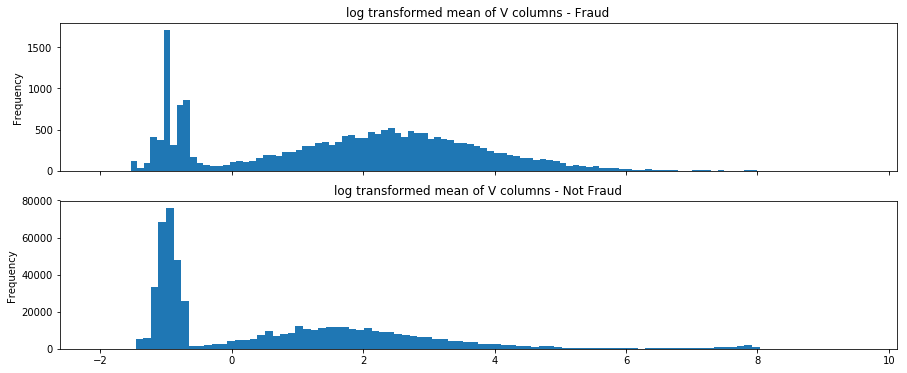

In [88]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 6))
train_tran.loc[train_tran['isFraud'] == 1]['v_mean'] \
    .apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='log transformed mean of V columns - Fraud',
          ax=ax1)
train_tran.loc[train_tran['isFraud'] == 0]['v_mean'] \
    .apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='log transformed mean of V columns - Not Fraud',
          ax=ax2)
plt.show()

#### train_identity.csv의 DeviceInfo plot 그려보기

In [47]:
# DeviceCount, DeviceInfo 두 개의 열을 갖는 DF를 만듭니다.
group = pd.DataFrame()
group['DeviceCount'] = train_tran.groupby(['DeviceInfo'])['DeviceInfo'].count()
group['DeviceInfo'] = group.index

# top 30개 Device들에 대해 sort합니다. 
group_top = group.sort_values(by='DeviceCount',ascending=False).head(30)

plt.figure(figsize=(25, 10))
sns.set(color_codes=True)
sns.set(font_scale = 1.3)
ax = sns.barplot(x="DeviceInfo", y="DeviceCount", data=group_top)
xt = plt.xticks(rotation=60)

KeyError: 'DeviceInfo'

1등이 Windows, 2등이 IOS Device, 3등이 MacOS인것을 확인할 수 있습니다. 또한 주로 desktop에서 결제를 하는 것으로 보입니다.

위 도표들의 결과를 종합해 보면 우선 target의 `isFraud`가 매우 unbalance하며, 사용자가 구입한 제품의 종류(`ProductCD`) 또한 매우 unbalance합니다.

In [ ]:
# Free memory
del test, train_tran, train_iden, test_tran, test_iden
print('test, train_tran, train_iden, test_tran, test_iden has been removed.')

#### 결측치 찾아 메우기

In [ ]:
# Finding missing data
def find_missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [ ]:
print(train.isnull().values.any())
display(find_missing_data(train), find_missing_data(X_test))

In [ ]:
# do fillna
train = train.fillna(-999)
X_test = X_test.fillna(-999)